In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
## update data
def filter_df(df):
    thresh=8
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[df.index.get_level_values('age').isin(ages_greater)]

In [5]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
male_df=filter_df(male_df)
male_df = male_df.query('age<100')

In [7]:
long_df=male_df.copy()
# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_df.index.get_level_values('age').unique())
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]
long_df = long_df[long_df.index.get_level_values('age').isin(lowest_day_entries)]
long_df = long_df.rename_axis(index={'age': 'age_old'})
long_df['age'] = np.floor(long_df.index.get_level_values('age_old')).astype(int)
long_df.set_index('age',inplace=True, append=True)


In [8]:
# avarage per age or session
m_df= long_df.groupby(['age','uuid','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [9]:
# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [10]:
df_indv = m_norm[syll_sort_m]

/tmp/ipykernel_5139/2905788502.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 4, n + 1)


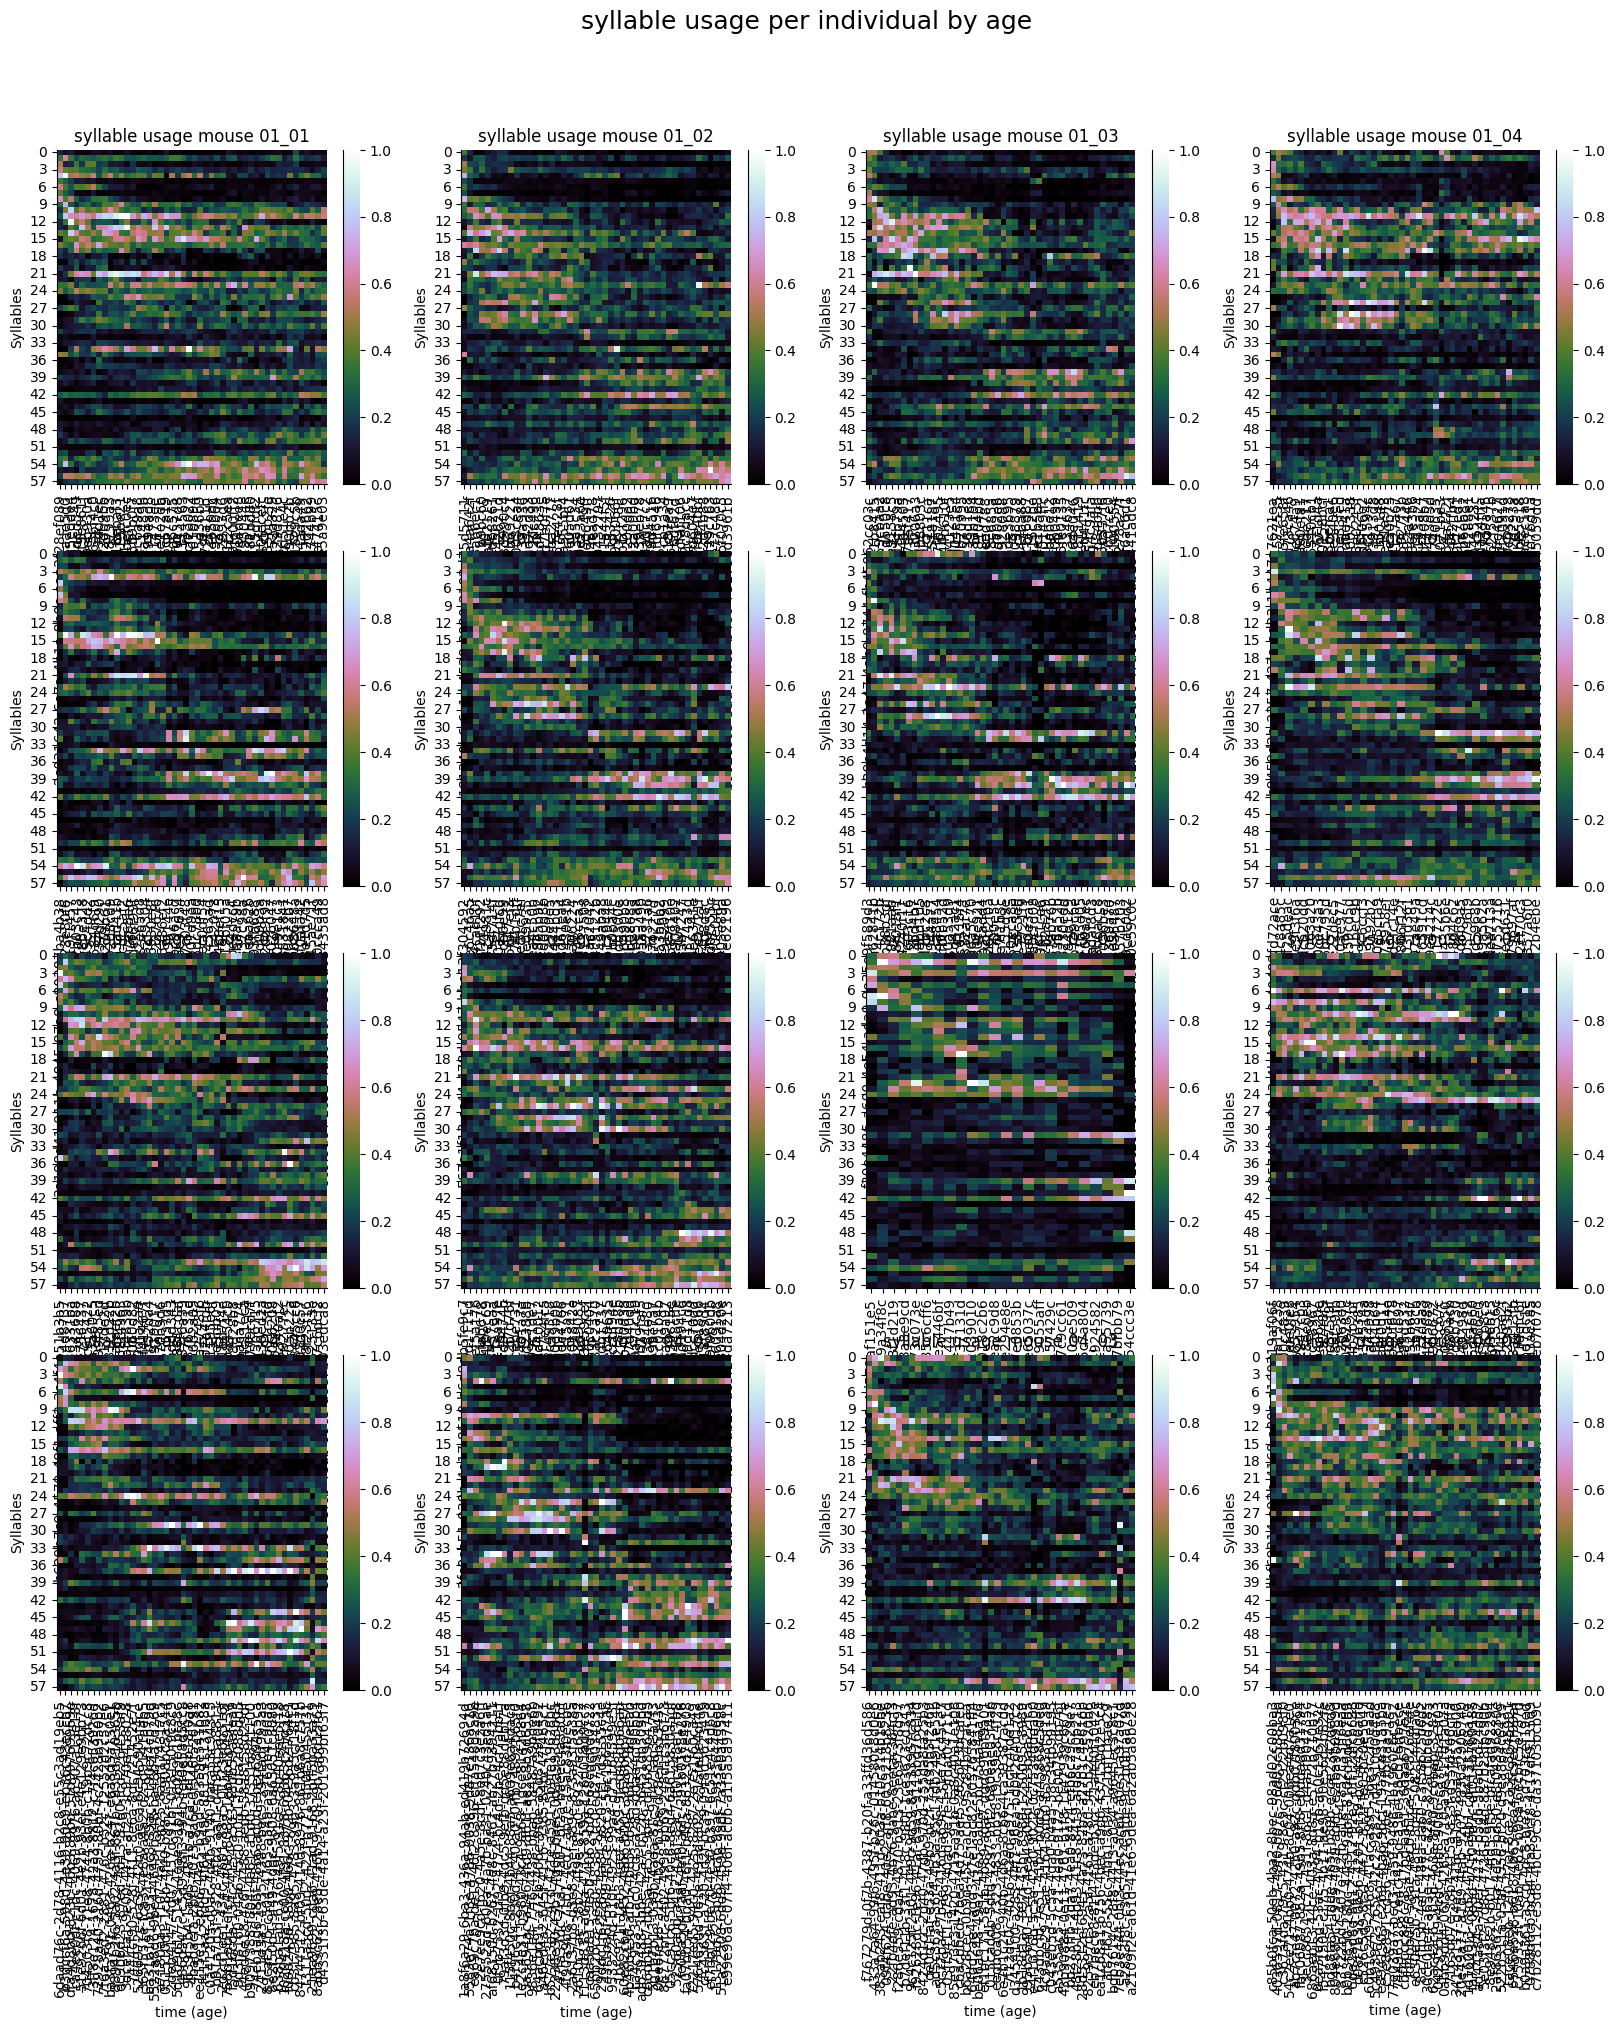

In [11]:
# for males
fig, ax = plt.subplots()
fig.set_size_inches(20,20)

plt.suptitle("syllable usage per individual by age", fontsize=18, y=0.95)

n=0
for mouse,_df in enumerate(df_indv.groupby('mouse')):
    m=_df[0]
    ages = _df[1].index.get_level_values(1).to_numpy()
    data_temp = _df[1].to_numpy()
    ax = plt.subplot(4, 4, n + 1)
    sns.heatmap(data_temp.T,cmap = 'cubehelix', xticklabels= ages)
    ax.set_title('syllable usage mouse ' + str(m))
    ax.set_ylabel('Syllables',fontsize=10)
    ax.set_xlabel('time (age)',fontsize=10)
    #ax.set_ylim(0,0.12)
    #ax = plt.subplot(10, 7, n + 1)
    #sns.heatmap(kld_temp,ax=ax, vmax=1.0)
    n=n+1
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'indv_syllable_usage_over_life_heatmaps_resampled.pdf')